# Declare libraries

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# Prepare data

In [2]:
# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter samples for classes 0, 1, 2
class_indices = [0, 1, 2]
filtered_data = [(image, label) for image, label in train_dataset if label in class_indices]

# Create new dataset containing only samples from classes 0, 1, 2
class FilteredMNIST(Dataset):
    def __init__(self, filtered_data):
        self.filtered_data = filtered_data

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        return self.filtered_data[idx]

# Create new DataLoader
train_dataset = FilteredMNIST(filtered_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.15MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.0kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


torch.Size([128, 1, 32, 32])


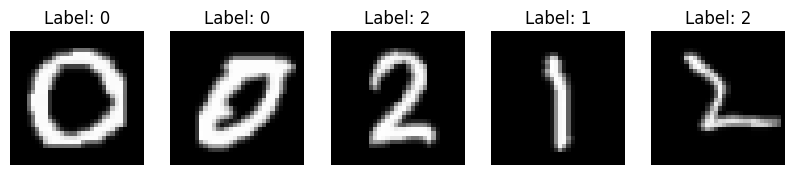

In [ ]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

# Display some sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.show()

# Build model

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height * width).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(batch_size, channels, height, width)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [4]:
class Diffusion:
    def __init__(self,
                 noise_steps=1000,
                 beta_start=1e-4,
                 beta_end=0.02,
                 img_size=256,
                 img_channels=3,
                 device="cuda"):

        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.img_channels = img_channels
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, plot_image=False):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, self.img_channels, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                if plot_image == True and i % (self.noise_steps // 10) == 1:
                    # Create image grid
                    grid_img = torchvision.utils.make_grid(x, nrow=8, padding=2)
                    final_image = grid_img.permute(1, 2, 0).cpu().numpy()
                    plt.figure(figsize=(8, 8))
                    plt.imshow(final_image, cmap="gray")
                    plt.axis('off')
                    plt.show()

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

# Training

In [5]:
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [6]:
def train(params):
    device = params["device"]
    img_channels = params["image_channels"]
    dataloader = train_loader
    model = UNet(c_in=1, c_out=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=params["lr"])
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=params["image_size"],
                          img_channels=img_channels,
                          device=device)
    loss_min = float('inf')
    for epoch in range(params["epochs"]+1):
        print(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for _, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            if loss < loss_min:
              loss_min = loss
              torch.save(model.state_dict(), "best_model.pth")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())

        os.makedirs(os.path.join("results", params["run_name"]), exist_ok=True)
        os.makedirs(os.path.join("models", params["run_name"]), exist_ok=True)
        torch.save(model.state_dict(), os.path.join("models", params["run_name"], f"ckpt.pt"))
        if epoch % 10 == 0:
            sampled_images = diffusion.sample(model, n=images.shape[0])
            save_images(sampled_images, os.path.join("results", params["run_name"], f"{epoch}.jpg"))

In [ ]:
params = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'lr': 1e-4,
    'epochs': 50,
    'image_size': 32,
    'image_channels': 1,
    'run_name': 'default_run'
}

train(params)

# Sampling

In [10]:
torch.manual_seed(10)
device = params["device"]
img_channels = params["image_channels"]
model = UNet(c_in=1, c_out=1).to(device)
model.load_state_dict(torch.load("best_diffusion.pth"))

def visualize_diffusion_sampling(steps=1000, n_samples=48):
    diffusion = Diffusion(noise_steps=steps,
                          img_size=params["image_size"],
                          img_channels=img_channels,
                          device=device)
    start_time = time.time()
    diffusion.sample(model, n=n_samples, plot_image=True)
    end_time = time.time()
    print(f"\nSampling time: {end_time - start_time} seconds")

In [11]:
visualize_diffusion_sampling(steps=1000)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
visualize_diffusion_sampling(steps=500)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
visualize_diffusion_sampling(steps=100)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
visualize_diffusion_sampling(steps=20)

Output hidden; open in https://colab.research.google.com to view.